### Preamble

Contains imports and some utility code.

In [1]:
!curl -s "https://raw.githubusercontent.com/Yoonsen/Modules/master/module_update.py" > "module_update.py"

In [2]:
from module_update import update, css, code_toggle

In [3]:
css()

In [4]:
update('nbtext', overwrite=True)  # may remove overwrite=True
update('graph_networkx_louvain', overwrite=True)
import graph_networkx_louvain as gnl
import nbtext as nb
import networkx as nx
%matplotlib inline

Updated file `C:\Users\larsj\Documents\GitHub\Tutorial-DHN2019\nbtext.py`

Updated file `C:\Users\larsj\Documents\GitHub\Tutorial-DHN2019\graph_networkx_louvain.py`

In [5]:
def frame_sort(frame, by=0):
    return frame.sort_values(by=by, ascending=False)

In [6]:
import warnings
warnings.filterwarnings('ignore')

# Collocations

The term collocation has traditionally been restricted to words that are juxtaposed together as phrases like “strong coffee”, “strict regime” or “eat dinner”. Here we take collocations to be realized as skipgrams, or as word pairs that simply cooccur within a context which in itself is a contiguous sequence of words, typically a paragraph or a window of n words around a given word. Juxtaposed collocates will also be part of the result set. 


### Define a corpus

Using dewey decimal to restrict corpus 

In [7]:
corpus_urns = nb.get_urn({
    'ddk':"641%", 
    'year':1960, 
    'next':60, 
    'lang':'nob', 
    'limit': 200
})

print(len(corpus_urns), corpus_urns[:5])

200 [[2010071903040, 'Rivera, Guadalupe', 'Fridas fiestas', 1997], [2014030548010, '', 'Vidunderlig gresk', 2007], [2014033148041, 'Gööck, Roland', 'God mat fra hele verden', 1982], [2016062748049, 'Petersen, Bengt', 'Fiskekokebok', 1986], [2015102048040, 'Skår, Astrid', 'Mat for sommerdager', 2001]]


### Make a collocation for a word from the corpus

Here we go step by step. The process may be collected into one general script.

First, collect the words around a given word and count the result.

In [8]:
collword = 'kjøtt'

In [9]:
coll = nb.urn_coll(collword, urns = corpus_urns, after = 5, before = 5, limit = 1000)

In [10]:
coll.head()

,0
",",5347
.,4134
og,3084
),1524
(,1352


We want to measure how this differs from a reference. Two point themselves out, the collection of all books, and the corpus itself.

All books

In [11]:
tot = nb.frame(nb.totals(top = 50000))

In [12]:
tot.head()

,0
.,1265723110
",",1105303412
og,543432056
i,460246057
det,273411583


The corpus

In [13]:
corpus_tot = nb.aggregate_urns(corpus_urns)

Make it into a frame

In [14]:
corpus_tot = frame_sort(nb.frame(corpus_tot))

In [15]:
corpus_tot.head()

,0
.,584653
",",447817
og,350153
i,277515
med,167291


So we have three wordbags, the collocation, the corpus counts, and the total count of all books. Let us also normalize them, so values more easily can be compared.

In [16]:
nb.normalize_corpus_dataframe(corpus_tot)
nb.normalize_corpus_dataframe(tot)
nb.normalize_corpus_dataframe(coll)

True

In [17]:
coll_all = frame_sort(coll**1.0/tot)

In [18]:
coll_all.head(20)

,0
grillet,1954.340746
flesk,752.891677
stekt,751.724284
biff,711.311098
magert,706.014333
ferskt,648.681020
røkt,639.727150
innmat,580.777769
lagvis,536.121423
steking,469.016733


Compare the effect of exponent choice below. The formula for computing the collocation is:

$coll(x)=\frac{x^e}{r(x)}$ for some exponent $e$ and reference value $r(x)$ for $x$. The formula makes sure that higher values of $x$ compared to $r(x)$, scores higher, and the exponent penalizes small values of $x$, compared to the corpus.

Look at the values, and note where the numbers are equal. In a real situation, one may want to remove all hapax from the corpus.

In Python, the computation takes the following form:

In [34]:
coll_corp = frame_sort(coll**1.7/corpus_tot)

In [35]:
coll_corp.head(20)

,0
fisk,1.493377
flesk,0.656297
Ferskt,0.560256
ferskt,0.505955
fjærfe,0.485484
Garnityrnavn,0.396013
Opplysningskontoret,0.340966
magert,0.337029
",",0.335862
grillet,0.320661


A quick check with concordances may point to:

In [21]:
nb.get_urnkonk('fisk', {'urns':corpus_urns, 'limit':50})

"Fridas fiestas, Rivera, Guadalupe, 1997","renskåret , fast , hvit",fisk,", skåret i store biter"
"Fridas fiestas, Rivera, Guadalupe, 1997",750 g fersk,fisk,"med fast , hvitt kjøtt"
"Vidunderlig gresk, , 2007","og salater , grillet fersk",fisk,"og kjøtt ,"
"Vidunderlig gresk, , 2007",2 Tilsett,fisk,og reker i gryten .
"Vidunderlig gresk, , 2007",over at grekerne bruker mye,fisk,og sjømat i sitt kjøkken
"Vidunderlig gresk, , 2007",retten . Tradisjonell gresk bakt,fisk,blir for eksempel bakt på
"Vidunderlig gresk, , 2007",Ovnsstekt,fisk,med lime
"God mat fra hele verden, Gööck, Roland, 1982",i skogen og av den,fisk,vi trakk opp av havet
"God mat fra hele verden, Gööck, Roland, 1982","g selleri , 2 kg",fisk,", ( ål brukes meget"
"God mat fra hele verden, Gööck, Roland, 1982",tilbehør til stekt kjøtt og,fisk,.
"God mat fra hele verden, Gööck, Roland, 1982","ferskt kjøtt og skinke ,",fisk,og skalldyr .


In [22]:
nb.get_urnkonk('saus', {'urns':corpus_urns, 'limit':50})

"Fridas fiestas, Rivera, Guadalupe, 1997",", badet i en sursøt",saus,"med tomater og løkskiver ,"
"Fridas fiestas, Rivera, Guadalupe, 1997",huauzontles med grønn og rød,saus,og chilier fylt med picadillo
"Fridas fiestas, Rivera, Guadalupe, 1997",Over : Huauzontles i grønn,saus,.
"Fridas fiestas, Rivera, Guadalupe, 1997","picadillo , dekket med en",saus,av ferske valnøtter og pyntet
"Fridas fiestas, Rivera, Guadalupe, 1997",dem være helt dekket av,saus,. Legg dem på et
"Vidunderlig gresk, , 2007",kokt inn til en tykk,saus,.
"Vidunderlig gresk, , 2007",Sjømat brukes også som,saus,til pasta eller som tilsetning
"Vidunderlig gresk, , 2007",Bønnene skal være dekket med,saus,. Tilsett litt ekstra vann
"Vidunderlig gresk, , 2007",dem varme eller kalde med,saus,og gresk yoghurt ved siden
"God mat fra hele verden, Gööck, Roland, 1982",om norske kjøttkaker i brun,saus,og i stedet iler glad
"God mat fra hele verden, Gööck, Roland, 1982",hvis man ønsker en tykkere,saus,. Server fruktene varme og


## Inspect collocations

Let's make a huge graph. Each node is expanded. We do the exercise for both reference corpuses (corpora).

In [36]:
coll_corp.index[:20] 

Index(['fisk', 'flesk', 'Ferskt', 'ferskt', 'fjærfe', 'Garnityrnavn',
       'Opplysningskontoret', 'magert', ',', 'grillet', 'rensk',
       '(lammekotelett).', 'fjærkre', 'rått', 'grønnsaker', 'stekt', ')',
       'Skrapet', '(tournedos),', 'blodig'],
      dtype='object')

In [37]:
words_to_expand = list(coll_corp.index[:11])
words_to_expand

['fisk',
 'flesk',
 'Ferskt',
 'ferskt',
 'fjærfe',
 'Garnityrnavn',
 'Opplysningskontoret',
 'magert',
 ',',
 'grillet',
 'rensk']

We want to create a collocation for each of the words, and collect all in a graph. We repeat the collocation making for each word in our list.

for each word make a collocation for that word using the corpus URNs:

In [38]:
collocations = {word: nb.urn_coll(word, urns=corpus_urns) for word in words_to_expand}

We may inspect the collocations:

In [39]:
for w in collocations:
    print(w, list(collocations[w].index[:11]))
    print()

fisk [',', '.', 'og', ')', 'i', 'til', 'eller', 'av', '(', 'kjøtt', 'med']

flesk [',', 'og', '.', 'g', 'eller', 'med', 'kjøtt', 'i', 'til', '1', 'stekt']

Ferskt ['.', 'kjøtt', 'og', ',', 'suppe', 'til', 'brød', 'i', 'er', 'eller', 'med']

ferskt [',', '.', 'og', 'kjøtt', 'med', 'brød', 'eller', 'til', 'g', 'av', 'i']

fjærfe [',', ')', '(', 'og', '.', 'til', 'kjøtt', 'Garnityrnavn', 'fisk', 'fugl', 'pulard']

Garnityrnavn [')', '.', '(', ',', ':', '-', 'Frankrike', '/', "'", '"', 'Hotel']

Opplysningskontoret ['for', '.', 'og', 'kjøtt', ',', 'grønnsaker', 'frukt', ':', 'no', 'i', 'fisk']

magert [',', 'g', '.', 'og', 'er', 'kjøtt', 'i', 'eller', 'svinekjøtt', '1', '2']

, [',', '.', ')', '(', '1', '2', '-', 'i', 'av', 'en', ':']

grillet [',', '.', 'med', 'og', 'eller', 'til', 'grillet', 'stekt', 'kjøtt', 'i', 'på']

rensk ['.', 'g', 'kg', 'ca.', 'kjøtt', ',', 'av', '1', 'kjøttdeig', '3', '600']



Normalize

In [40]:
for w in collocations:
    nb.normalize_corpus_dataframe(collocations[w])

These undergo same procedure as with the original

In [41]:
collocations_weight = {w:frame_sort(collocations[w]**1.7/corpus_tot) for w in collocations}

In [42]:
for w in collocations_weight:
    print(w, list(collocations_weight[w].index[:11]))
    print()

fisk ['skalldyr', 'kjøtt', 'fet', 'Fet', 'Garnityrnavn', 'Mager', 'fiskegryte,', 'barbe', 'Eksportutvalget', 'Amia', 'Raket']

flesk ['Eplepasta', 'slikjande', 'Kanelkrydret', 'suppeurter', 'Holm-Olsen', 'lettsaltet', 'duppe', 'kjøtt', 'Kumla', 'Lard', 'magert']

Ferskt ['mørningsmetoden', 'ripskremen', 'muskellagene', 'PeerGynt', 'vintersøndagsmat', 'oppdrettets', 'Salamiskiver', 'lerstur', 'hygienekontroll', 'varmevekslende', 'qrytcn']

ferskt ['slaktesesongen.', 'kjølevogner', 'Brodterninger', 'Lammelåra', 'agave-vann', 'Vossevangen', 'søndagsfrokosten,', 'synak', 'Suppedag', 'Småfolk', 'lavprisbutikken']

fjærfe ['pulard', 'kyllingsauté', 'kyllingkotelett', 'kyllingfrikassé', '(kyllingsauté),', 'fiåing', 'sjøtunge', 'ogpulard', 'babykylling', 'ballottiner', 'vårkylling']

Garnityrnavn [')', '(', '(jordbær),', '(isbombe),', '(sjøtunge).', 'Barberen', '(vannbakkelsboller),', '(kyllingfrikassé', '(omelett),', '(lammekotelett).', '.']

Opplysningskontoret ['www.frukt', 'www.godfisk', '

## Final step

Turn it all into a graph. Create a graph and populate it with edges.

In [43]:
# start with an empty list of edges

edges = []

In [44]:
# add elements from words_to_expand

for x in words_to_expand:
    edges.append((collword, x, float(coll_corp.loc[x])))


After the first edges are added, we can have a look at them

In [45]:
edges

[('kjøtt', 'fisk', 1.4933767590727702),
 ('kjøtt', 'flesk', 0.6562972863456087),
 ('kjøtt', 'Ferskt', 0.560256055795535),
 ('kjøtt', 'ferskt', 0.5059553339212863),
 ('kjøtt', 'fjærfe', 0.4854841535646835),
 ('kjøtt', 'Garnityrnavn', 0.39601259314378023),
 ('kjøtt', 'Opplysningskontoret', 0.3409661615411556),
 ('kjøtt', 'magert', 0.3370287880832176),
 ('kjøtt', ',', 0.3358620732400943),
 ('kjøtt', 'grillet', 0.3206608837211856),
 ('kjøtt', 'rensk', 0.303608335639196)]

Create a graph over the edges

In [46]:
G = nx.Graph()

Add the edges

In [47]:
G.add_weighted_edges_from(edges)

Draw the graph using module gnl

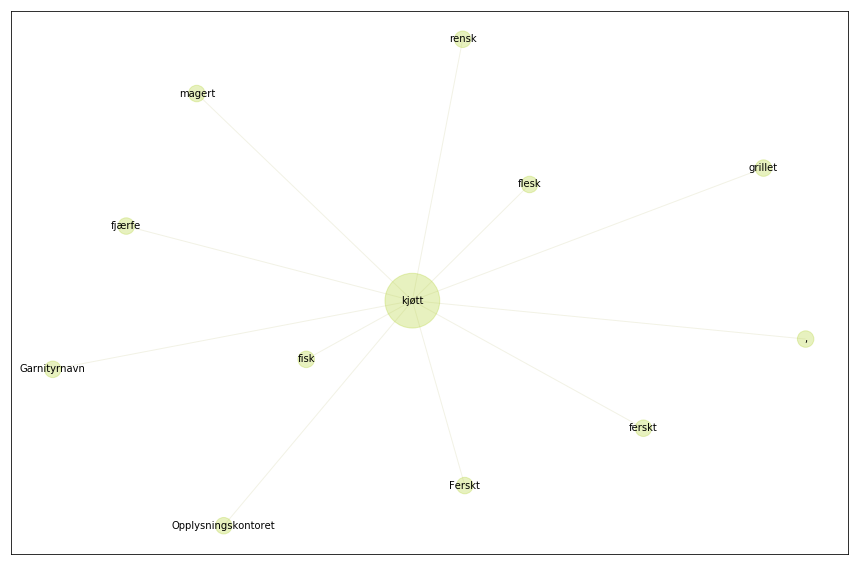

In [48]:
gnl.show_graph(G)

Next add all the edges from `collocations_weight`. We just select the 11 first, just like the first. This could be made sensitive to the actual structure of the collocation.

In [49]:
rest_edges = []

In [50]:
for w in collocations_weight:
    for word in collocations_weight[w].index[:11]:
        rest_edges.append((w, word, float(collocations_weight[w].loc[word])))

Add the latest edges to G

In [51]:
G.add_weighted_edges_from(rest_edges)

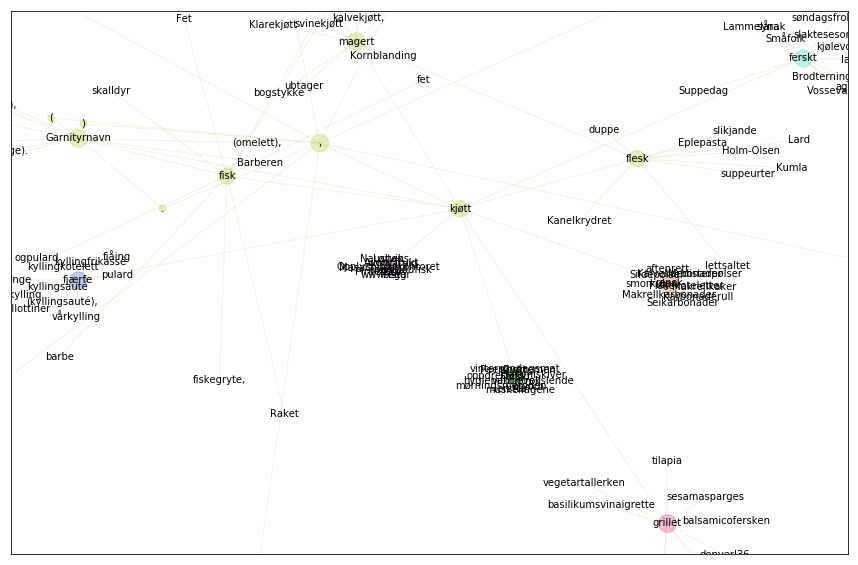

In [52]:
gnl.show_graph(G, spread = 0.3)

In [53]:
gnl.show_communities(G)

magert-, :  magert, ,, Garnityrnavn, flesk, kjøtt, fisk, ., ), (, Eplepasta, (vannbakkelsboller),, Kornblanding, (isbombe),, slikjande, Klarekjøtt, (omelett),, Eksportutvalget, bordsanger, ubtager, Lard, 2, ftlefl, Mager, skalldyr, (kyllingfrikassé, Hverc, duppe, Amia, bogstykke, ostestoff-, (sjøtunge)., :, 1, klarifikasjon, (jordbær),, ', Kumla, svinekjøtt, fiskegryte,, Kanelkrydret, Holm-Olsen, lettsaltet, Barberen, suppeurter, -, kalvekjøtt,, 3, (lammekotelett)., 4, fet, barbe, Fet, Raket

Ferskt-oppdrettets :  Ferskt, oppdrettets, Salamiskiver, mørningsmetoden, vintersøndagsmat, hygienekontroll, PeerGynt, varmevekslende, lerstur, ripskremen, qrytcn, muskellagene

ferskt-Brodterninger :  ferskt, Brodterninger, Lammelåra, Suppedag, søndagsfrokosten,, Småfolk, synak, agave-vann, slaktesesongen., kjølevogner, lavprisbutikken, Vossevangen

fjærfe-fiåing :  fjærfe, fiåing, pulard, ogpulard, vårkylling, ballottiner, kyllingsauté, babykylling, kyllingkotelett, kyllingfrikassé, sjøtunge, (k